## Imports

In [15]:
import torch
from torch.utils.data import Dataset
from typing import Tuple
import numpy as np
import requests
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc
from torchvision import transforms
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18

## Load Model

In [16]:
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 44)

ckpt = torch.load("./01_MIA_67.pt", map_location="cpu")

model.load_state_dict(ckpt)

/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_124750/4102427899.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions tha

<All keys matched successfully>

## Utils

In [19]:
class TaskDataset(Dataset):
    def __init__(self, transform=None):
        """
        Initialize the dataset with empty lists for IDs, images, and labels.
        Optionally apply image transformations.

        Args:
        - transform (callable, optional): Transformations to apply to images (e.g., resizing, normalization).
        """
        self.ids = []
        self.imgs = []
        self.labels = []
        self.transform = transform

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        """
        Fetch a single sample from the dataset.

        Args:
        - index (int): Index of the sample to retrieve.

        Returns:
        - Tuple: (ID, image, label)
        """
        id_ = self.ids[index]
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
        - int: Length of the dataset (number of samples).
        """
        return len(self.ids)


class MembershipDataset(Dataset):
    def __init__(self, ids, imgs, labels, memberships=None, transform=None):
        """
        Initialize the membership dataset with IDs, images, labels, and optional membership data.
        Optionally apply image transformations.

        Args:
        - ids (list): List of IDs for the samples.
        - imgs (list): List of image tensors.
        - labels (list): List of labels corresponding to each image.
        - memberships (list, optional): List of membership flags (e.g., 0 or 1). Default is None.
        - transform (callable, optional): Transformations to apply to images.
        """
        self.ids = ids
        self.imgs = imgs
        self.labels = labels
        self.memberships = memberships if memberships is not None else []
        self.transform = transform

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
        - int: Length of the dataset (number of samples).
        """
        return len(self.ids)

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int, int]:
        """
        Fetch a single sample from the membership dataset.

        Args:
        - index (int): Index of the sample to retrieve.

        Returns:
        - Tuple: (ID, image, label, membership)
        """
        id_ = self.ids[index]
        img = self.imgs[index]
        label = self.labels[index]
        membership = self.memberships[index] if len(self.memberships) > 0 else -1
        if self.transform:
            img = self.transform(img)

        return id_, img, label, membership

## Load Datasets

In [20]:
def load_dataset(filepath, transform=None):
    """
    Load a dataset from a file and return a MembershipDataset instance.

    Args:
    - filepath (str): Path to the dataset file.
    - transform (callable, optional): Transformations to apply to images.

    Returns:
    - MembershipDataset: The loaded dataset.
    """
    data = torch.load(filepath)

    ids = data.ids
    imgs = data.imgs
    labels = data.labels
    memberships = getattr(data, 'membership', None)
    return MembershipDataset(ids=ids, imgs=imgs, labels=labels, memberships=memberships, transform=transform)

def get_default_transforms():
    """
    Returns default image transformations for preprocessing.
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normaliser les canaux RGB
                             std=[0.229, 0.224, 0.225])

    """
    return transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    

transform = get_default_transforms()
priv_out_dataset = load_dataset('./priv_out.pt', transform)
pub_dataset = load_dataset('./pub.pt',transform)

/tmp/ipykernel_124750/1892151053.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(filepath)


## Preprocess dataset

Number of samples in PUB dataset: 20000
First PUB sample:
  ID: 166661
  Image shape: torch.Size([3, 32, 32])
  Label: 33
  Membership: 0
  Pixel value range: Min = -0.3176470398902893, Max = 1.0
Number of samples in PRIV OUT dataset: 20000
First PRIV OUT sample:
  ID: 55061
  Image shape: torch.Size([3, 32, 32])
  Label: 11
  Membership: None
  Pixel value range: Min = -0.30980390310287476, Max = 0.8352941274642944
=== Dataset Debugging Complete ===



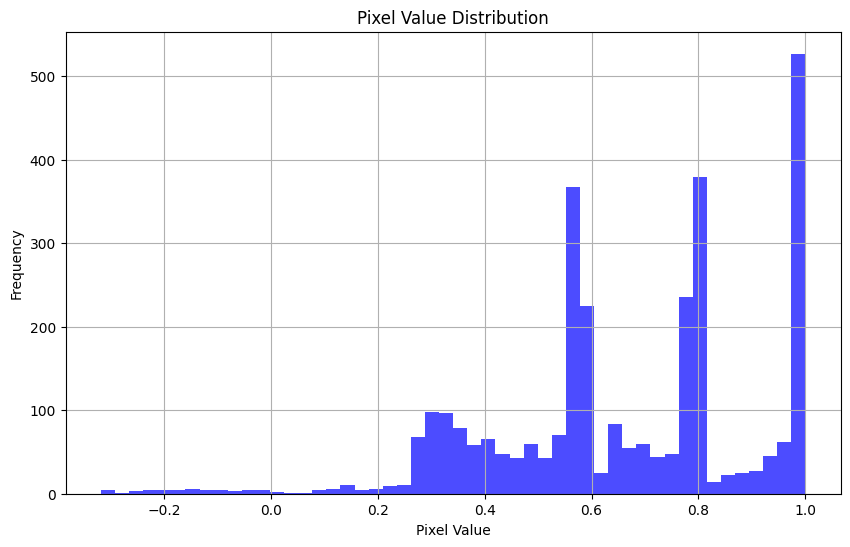

Proportion of images with membership = 1 in PUB dataset: 50.00%


In [21]:
# Check the PUB dataset
print(f"Number of samples in PUB dataset: {len(pub_dataset)}")
pub_sample = pub_dataset[4]

# Print details about the sample
print("First PUB sample:")
print(f"  ID: {pub_sample[0]}")
print(f"  Image shape: {pub_sample[1].shape}")
print(f"  Label: {pub_sample[2]}")
print(f"  Membership: {pub_sample[3]}")
print(f"  Pixel value range: Min = {pub_sample[1].min().item()}, Max = {pub_sample[1].max().item()}")

# Check the PRIV OUT dataset
print(f"Number of samples in PRIV OUT dataset: {len(priv_out_dataset)}")
priv_sample = priv_out_dataset[0]

# Print details about the sample
print("First PRIV OUT sample:")
print(f"  ID: {priv_sample[0]}")
print(f"  Image shape: {priv_sample[1].shape}")
print(f"  Label: {priv_sample[2]}")
print(f"  Membership: {priv_sample[3]}")
print(f"  Pixel value range: Min = {priv_sample[1].min().item()}, Max = {priv_sample[1].max().item()}")

print("=== Dataset Debugging Complete ===\n")



def plot_pixel_distribution(tensor):
    """
    Display the histogram of pixel values in an image tensor.
    
    Parameters:
    - tensor (torch.Tensor): The image tensor for which to display the pixel distribution.
    """
    pixel_values = tensor.numpy().flatten()
    
    # Create a histogram of the pixel values
    plt.figure(figsize=(10, 6))
    plt.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Plot the pixel value distribution of the image from the PUB sample
plot_pixel_distribution(pub_sample[1])


def calculate_membership_proportion(dataset):
    """
    Calculate and return the proportion of images in the dataset with membership = 1.
    
    Parameters:
    - dataset: A dataset where each item is a tuple (_, _, _, membership).
    
    Returns:
    - float: The proportion of images with membership = 1.
    """
    count_membership_1 = sum(1 for _, _, _, membership in dataset if membership == 1)
    total_images = len(dataset)
    proportion = count_membership_1 / total_images if total_images > 0 else 0
    return proportion

# Calculate and display the proportion of images with membership = 1 in the PUB dataset
pub_proportion = calculate_membership_proportion(pub_dataset)
print(f"Proportion of images with membership = 1 in PUB dataset: {pub_proportion:.2%}")


## Test model on the pub dataset

torch.Size([3, 32, 32])


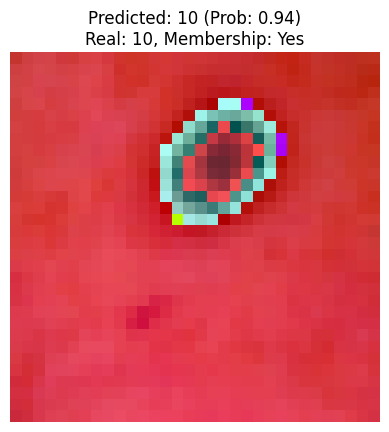

In [22]:
def show_random_image_with_prediction(dataset, model):
    """
    Displays a random image from the dataset along with the model's prediction.

    Parameters:
    - dataset: The dataset containing images, labels, and membership information.
    - model: The trained model used for predictions.
    """
    model.eval()
    
    # Randomly select an image from the dataset
    index = np.random.randint(0, len(dataset))
    _, img_tensor, label, membership = dataset[index]
    
    # Display the image
    print(img_tensor.shape)
    img = to_pil_image(img_tensor)
    plt.imshow(img)
    plt.axis('off')
    
    # Predict the label using the model
    with torch.no_grad():  
        outputs = model(img_tensor.unsqueeze(0)) 
        softmax = torch.nn.Softmax(dim=1) 
        probs = softmax(outputs)  
        predicted_label = probs.argmax(dim=1).item()  
        predicted_prob = probs.max().item()  
    
    plt.title(f'Predicted: {predicted_label} (Prob: {predicted_prob:.2f})\n'
              f'Real: {label}, Membership: {"Yes" if membership == 1 else "No"}')    
    plt.show()

# Example usage
show_random_image_with_prediction(pub_dataset, model)


## Features and labels extraction

In [23]:
def extract_features_and_labels(dataset, model):
    """
    Extracts features and labels from a dataset using the given model.

    Parameters:
    - dataset: The dataset containing images and membership information.
    - model: The model used to extract features (e.g., ResNet).

    Returns:
    - features: A list of extracted features for each image.
    - labels: A list of corresponding membership labels.
    """
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for data in dataset:
            _, img, _, membership = data
            
            # Obtain logits or features from the model
            outputs = model(img.unsqueeze(0))
            softmax = torch.nn.Softmax(dim=1)
            # probs = softmax(outputs).squeeze(0).numpy()
            probs = outputs.squeeze(0).numpy()
            
            # Store the features and corresponding labels
            features.append(probs)
            labels.append(membership)

    return features, labels

# Dataset preparation
features, labels = extract_features_and_labels(pub_dataset, model)
print('Data extraction completed')

Data extraction completed


## Attack Model training

In [25]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
# Uncomment the lines below to inspect a specific training example and its label
# print(X_train[5])
# print(y_train[5])

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=400, random_state=42)
rf_classifier.fit(X_train, y_train)
print('Model training completed')

# Make predictions and evaluate the model on the validation set
y_pred = rf_classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, rf_classifier.predict_proba(X_val)[:, 1])
print('Inference on the validation set completed')

# Display the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")


Model training completed
Inference on the validation set completed
Accuracy: 0.50625
ROC AUC: 0.5028725179532372


## Use the attack model for the priv_out dataset

In [28]:
def extract_features(dataset, model):
    """
    Extract features from a dataset using a pre-trained model.

    Parameters:
    - dataset: The dataset to extract features from, where each sample contains an image tensor.
    - model: The pre-trained model used to generate features.

    Returns:
    - features (list): A list of feature vectors extracted by the model.
    """
    model.eval()
    features = []
    
    with torch.no_grad():
        for _, img, _, _ in dataset:
            outputs = model(img.unsqueeze(0))
            # probs = softmax(outputs).squeeze(0).numpy()
            probs = outputs.squeeze(0).numpy()
            features.append(probs)
    
    return features

# Extract features for the PRIV OUT dataset using the pre-trained model
priv_out_features = extract_features(priv_out_dataset, model)

# Predict membership probabilities using the Random Forest classifier
priv_out_probabilities = rf_classifier.predict_proba(priv_out_features)[:, 1]
print("First predicted membership probabilities for the PRIV OUT dataset:")
print(priv_out_probabilities[:5])

First predicted membership probabilities for the PRIV OUT dataset:
[0.475  0.51   0.5225 0.535  0.47  ]


## File submission creation

In [29]:
ids = priv_out_dataset.ids
scores = priv_out_probabilities

# Create the DataFrame
submission_df = pd.DataFrame(
    {
        "ids": ids,
        "score": scores,
    }
)

# Save the DataFrame to a CSV file
submission_df.to_csv("./submission.csv", index=False)

print("Submission file 'submission.csv' created.")

Submission file 'submission.csv' created.


## Send the results

In [30]:
token = "[a_real_token]"

with open("submission.csv", "rb") as f:
    response = requests.post(
        "[URL_server]",
        files={"file": f},
        headers={"token": token},
    )

# Print the server's response
print(response.json())

{'TPR@FPR=0.05': 0.049, 'AUC': 0.5065623333333333}
